In [16]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
class ImageEditor:
    address=''
    rows=0
    cols=0
    imageObj=None
    imageArray=None
    colorPalate=None
    pixelClassification=None
    borderWidth=0;
    palateRows=None
    palateCols=None
    imageArrayOrginal=None
    imageObjOrginal=None
    def __init__(self,address):
        self.address=address
        self.imageObj=Image.open(self.address)
        self.imageArray=np.array(self.imageObj,dtype=np.uint8)
        self.imageArrayOrginal=np.array(self.imageObj,dtype=np.uint8)
        self.imageObjOrginal=Image.open(self.address)
        self.setRows()
        self.setCols()
    def setRows(self):
        self.rows=self.imageArray.shape[0]
    def setCols(self):
        self.cols=self.imageArray.shape[1]
    def greyScale(self,intensity=10):
        intensity=intensity/10
        for i in range(0,self.rows):
            for j in range(0,self.cols):
                index=self.imageArray[i,j,:].argmax(axis=0)
                if(index==0):
                    self.imageArray[i,j,1]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,2]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,index]= self.imageArray[i,j,index]*intensity
                elif(index==1):
                    self.imageArray[i,j,0]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,2]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,index]= self.imageArray[i,j,index]*intensity
                else:
                    self.imageArray[i,j,0]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,1]=self.imageArray[i,j,index]*intensity
                    self.imageArray[i,j,index]= self.imageArray[i,j,index]*intensity
        self.imageObj=Image.fromarray(self.imageArray)
    def addBorder(self,width=1,r=0,g=0,b=0):
        self.borderWidth+=width
        row=np.zeros([width,self.cols,3],dtype=np.uint8)
        col=np.zeros([self.rows+width*2,width,3],dtype=np.uint8) 
        row[:,:,:]=[r,g,b]
        col[:,:,:]=[r,g,b]
        test=np.vstack((row,self.imageArray))
        test=np.vstack((test,row))
        test=np.hstack((col,test))
        test=np.hstack((test,col))
        self.imageObj=Image.fromarray(test)
        self.imageArray=test
        self.rows=self.imageArray.shape[0]
        self.cols=self.imageArray.shape[1]
        return
    def pixilate(self):
        for i in range(1,self.rows-3,3):
            for j in range(1,self.cols-3,3):
                self.imageArray[i-1,j-1,:]=self.imageArray[i,j,:]
                self.imageArray[i-1,j,:]=self.imageArray[i,j,:]
                self.imageArray[i-1,j+1,:]=self.imageArray[i,j,:]
                self.imageArray[i,j-1,:]=self.imageArray[i,j,:]
                self.imageArray[i,j+1,:]=self.imageArray[i,j,:]
                self.imageArray[i+1,j-1,:]=self.imageArray[i,j,:]
                self.imageArray[i+1,j,:]=self.imageArray[i,j,:]
                self.imageArray[i+1,j+1,:]=self.imageArray[i,j,:]
        self.imageObj=Image.fromarray(self.imageArray)
        return
    def pixilate1(self,stride):
        stepSize=stride*2+1
        for i in range(stride,self.rows-stepSize,stepSize):
            for j in range(stride,self.cols-stepSize,stepSize):
                for k in range(1,stride):
                    self.imageArray[i-k,j-k,:]=self.imageArray[i,j,:]
                    self.imageArray[i-k,j,:]=self.imageArray[i,j,:]
                    self.imageArray[i-k,j+k,:]=self.imageArray[i,j,:]
                    self.imageArray[i,j-k,:]=self.imageArray[i,j,:]
                    self.imageArray[i,j+k,:]=self.imageArray[i,j,:]
                    self.imageArray[i+k,j-k,:]=self.imageArray[i,j,:]
                    self.imageArray[i+k,j,:]=self.imageArray[i,j,:]
                    self.imageArray[i+k,j+k,:]=self.imageArray[i,j,:]
        self.imageObj=Image.fromarray(self.imageArray)
        return
    def getColorPalate(self,n=2,m=4):
        self.palateRows=n
        self.palateCols=m
        X=[]
        for i in range(self.borderWidth,self.imageArray.shape[0]-self.borderWidth):
            for j in range(self.borderWidth,self.imageArray.shape[1]-self.borderWidth):
                X.append(self.imageArray[i,j,:])
        kmeans = KMeans(n_clusters=n*m, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        self.colorPalate=kmeans.cluster_centers_
        self.pixelClassification=kmeans.predict(X)
        return 
    def showColorPalate(self):
        projection=np.zeros([self.palateRows*100,self.palateCols*100,3],dtype=np.uint8)
        k=0
        for i in range(0,self.palateRows*100,100):
            for j in range(0,self.palateCols*100,100):
                projection[i:i+100,j:j+100,:]=self.colorPalate[k]
                k+=1
        Image.fromarray(projection).show()
    def artifyImage(self):
        k=0
        for i in range(self.borderWidth,self.rows-self.borderWidth):
            for j in range(self.borderWidth,self.cols-self.borderWidth):
                classification=self.pixelClassification[k]
                colorFill=self.colorPalate[classification]
                self.imageArray[i,j,:]=colorFill
                k+=1
        self.imageObj=Image.fromarray(self.imageArray)
    def revertToOrginal(self):
        self.imageArray=self.imageArrayOrginal
        self.imageObj=self.imageObjOrginal
        self.borderWidth=0
        self.setRows()
        self.setRows()
    def show(self):
        
        self.imageObj.show()
    def save(self,address):
        self.imageObj.save(address)
    def convertToHsv(self):
        for i in range(len(self.colorPalate)):
            r=self.colorPalate[i][0]
            g=self.colorPalate[i][1]
            b=self.colorPalate[i][2]
            h,s,v=rgb_to_hsv(r,g,b)
            rgb=hsv2rgb(h,s,v)
            r=rgb[0]
            g=rgb[1]
            b=rgb[2]
            self.colorPalate[i][0]=r
            self.colorPalate[i][1]=g
            self.colorPalate[i][2]=b
    def save(self,path):
        self.imageObj.save(path)
            

In [17]:

import colorsys
def rgb_to_hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    hn=h
    sn=(s)**0.75+0.05
    vn=(s)**0.75+0.05
    return hn, sn, vn
def hsv2rgb(h,s,v):
    return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

In [27]:
obj=ImageEditor('C:/Users/Socrates/Pictures/test4.png')

In [28]:

obj.addBorder(20,100,255,255)
obj.getColorPalate(4,4)


In [29]:
obj.showColorPalate()

In [22]:
obj.artifyImage()

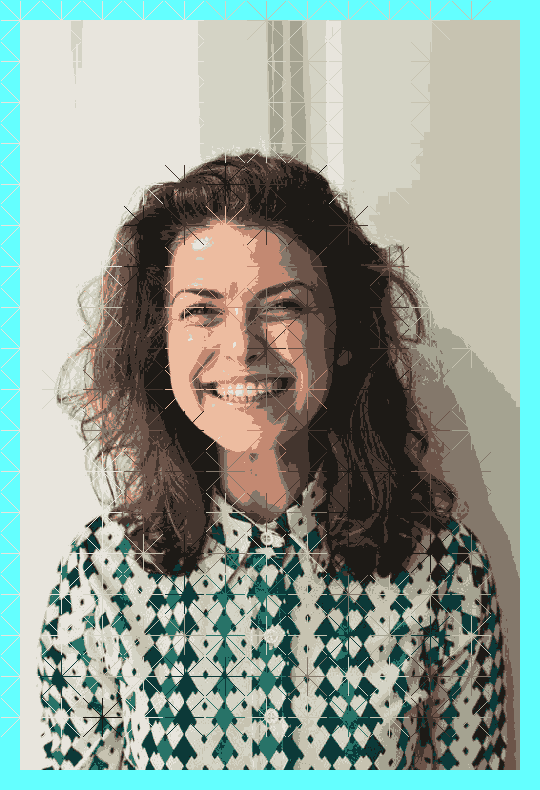

In [26]:
obj.imageObj

In [25]:
obj.save('C:/Users/Socrates/Pictures/art10.png')

In [24]:
obj.pixilate1(20)

In [107]:
obj.greyScale()

In [126]:
obj.pixilate()